<a href="https://colab.research.google.com/github/yamac0/IE423/blob/main/task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialize

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dfBnk = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/bank/bank_full.csv')

In [5]:
dfBnk.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Analyze Data

In [6]:
#how much of the y column data is yes or no
dfBnk['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [7]:
dfBnk[(dfBnk['balance'] == 0) & (dfBnk['y'] == 'yes')].shape[0]

292

<Axes: xlabel='balance', ylabel='Count'>

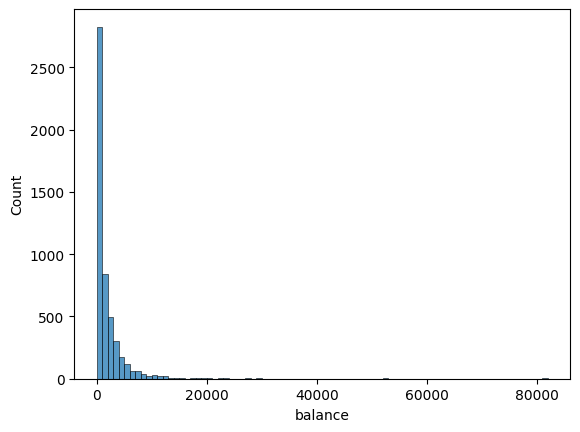

In [8]:
import seaborn as sns
sns.histplot(data=dfBnk[dfBnk['y'] == 'yes'], x='balance', bins=range(0, dfBnk[dfBnk['y'] == 'yes']['balance'].max() + 1000, 1000))

In [9]:
dfBnk[(dfBnk['balance']>0) & (dfBnk['balance']<1000) & (dfBnk['y'] == 'yes')].shape[0]

2534

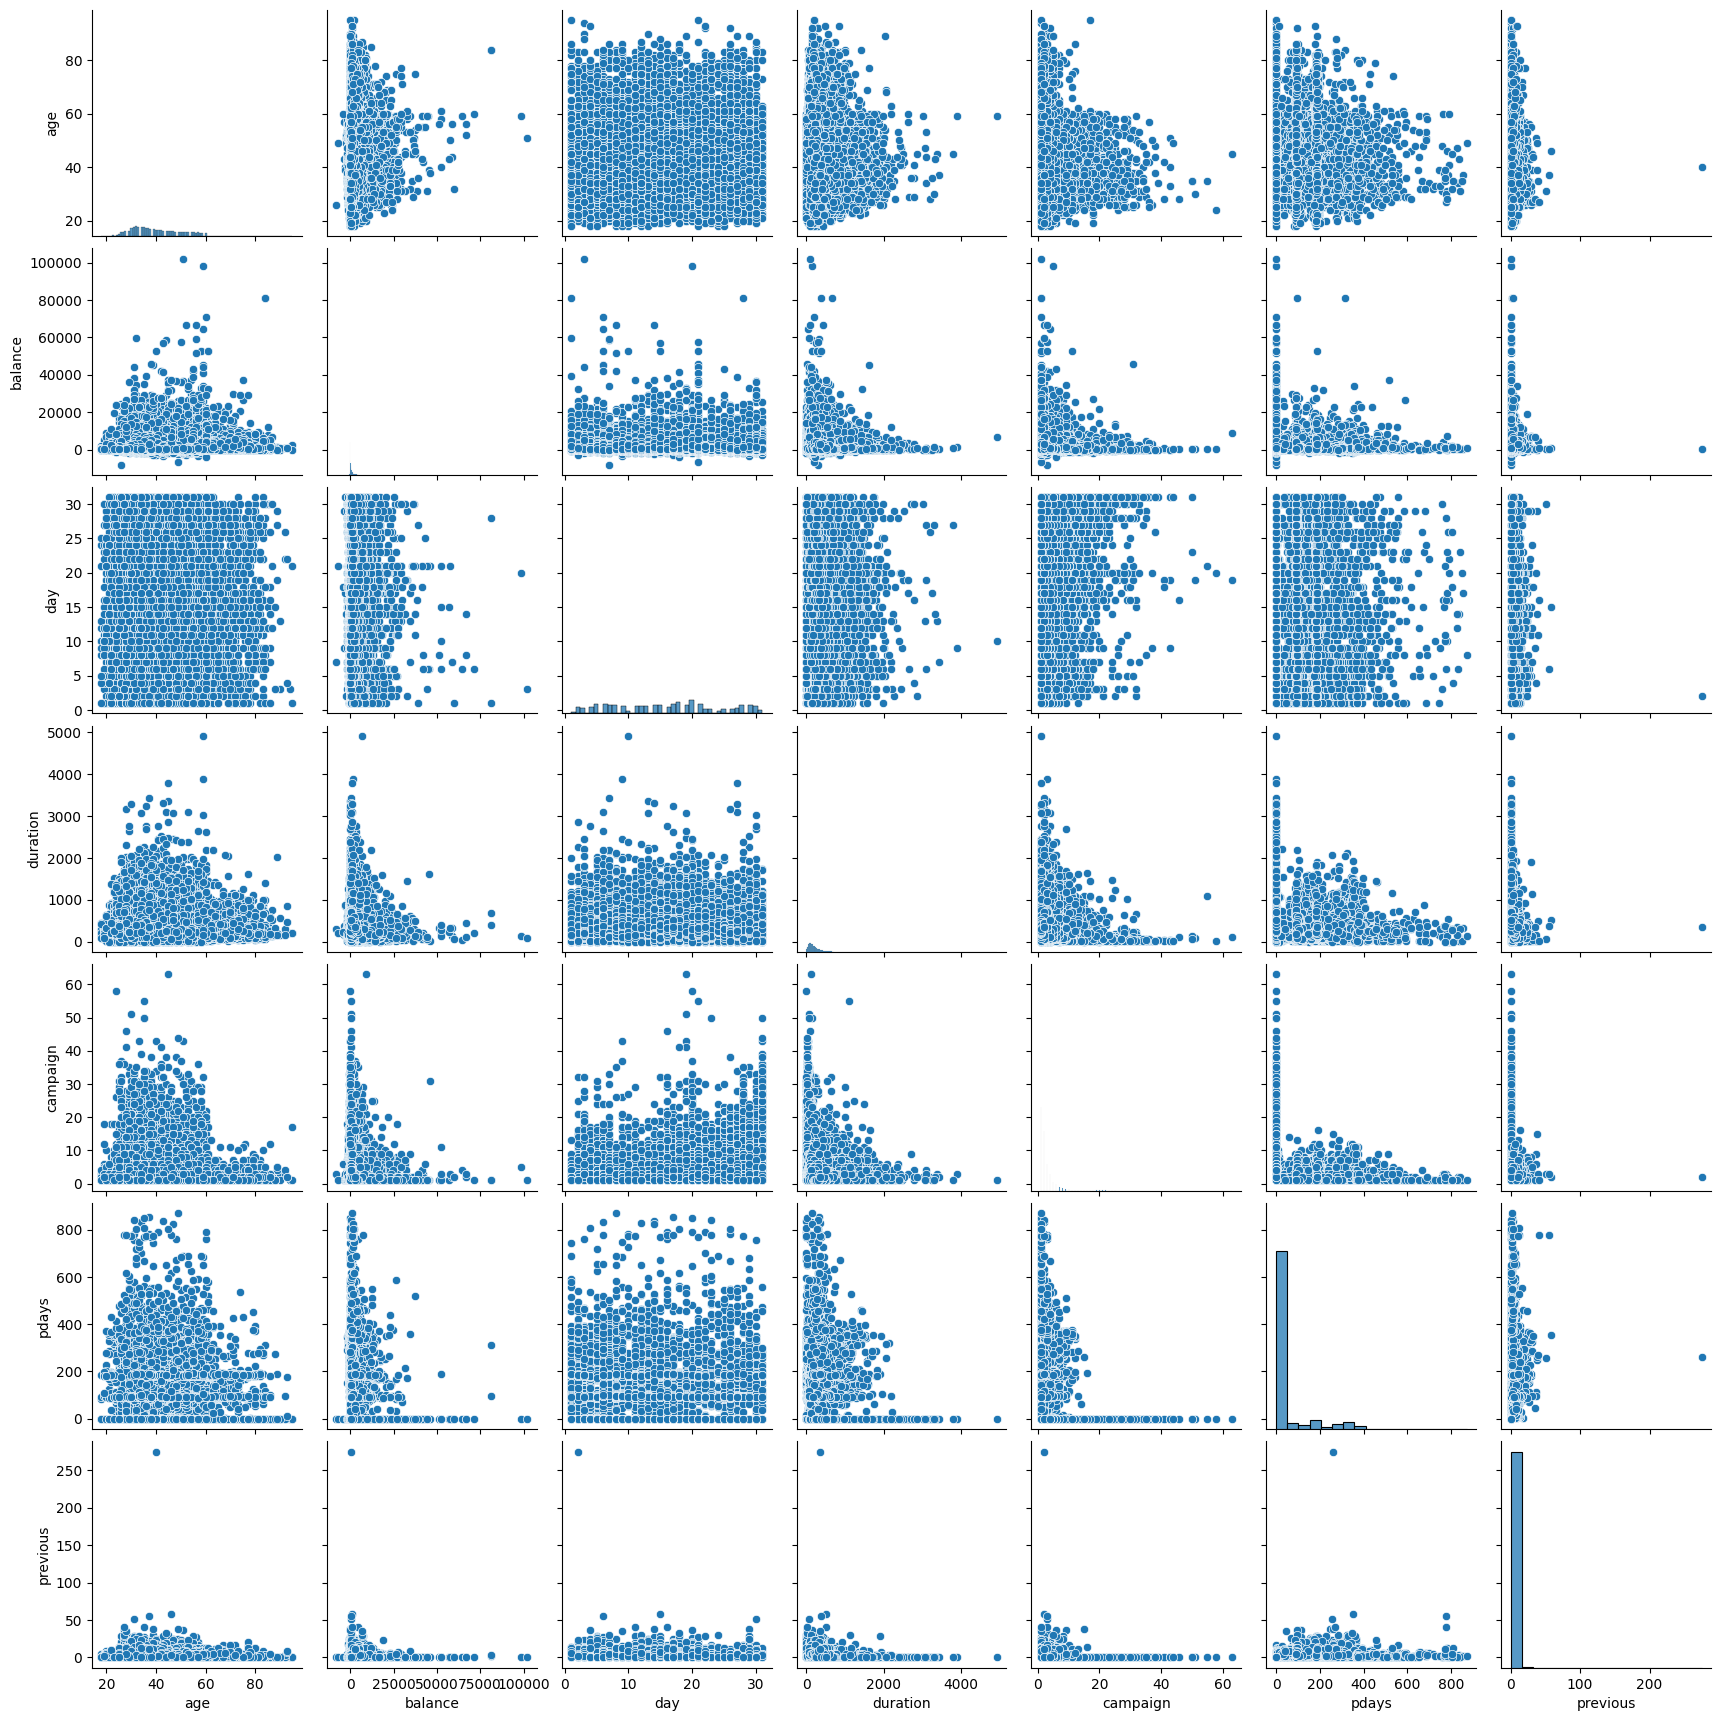

In [10]:
# Plot pair-wise relationships in the dataset
import seaborn as sns
sns.pairplot(dfBnk)

There doesn't seem to be any significant correlations going on.  Let's dig deeper into the chol by age plot...

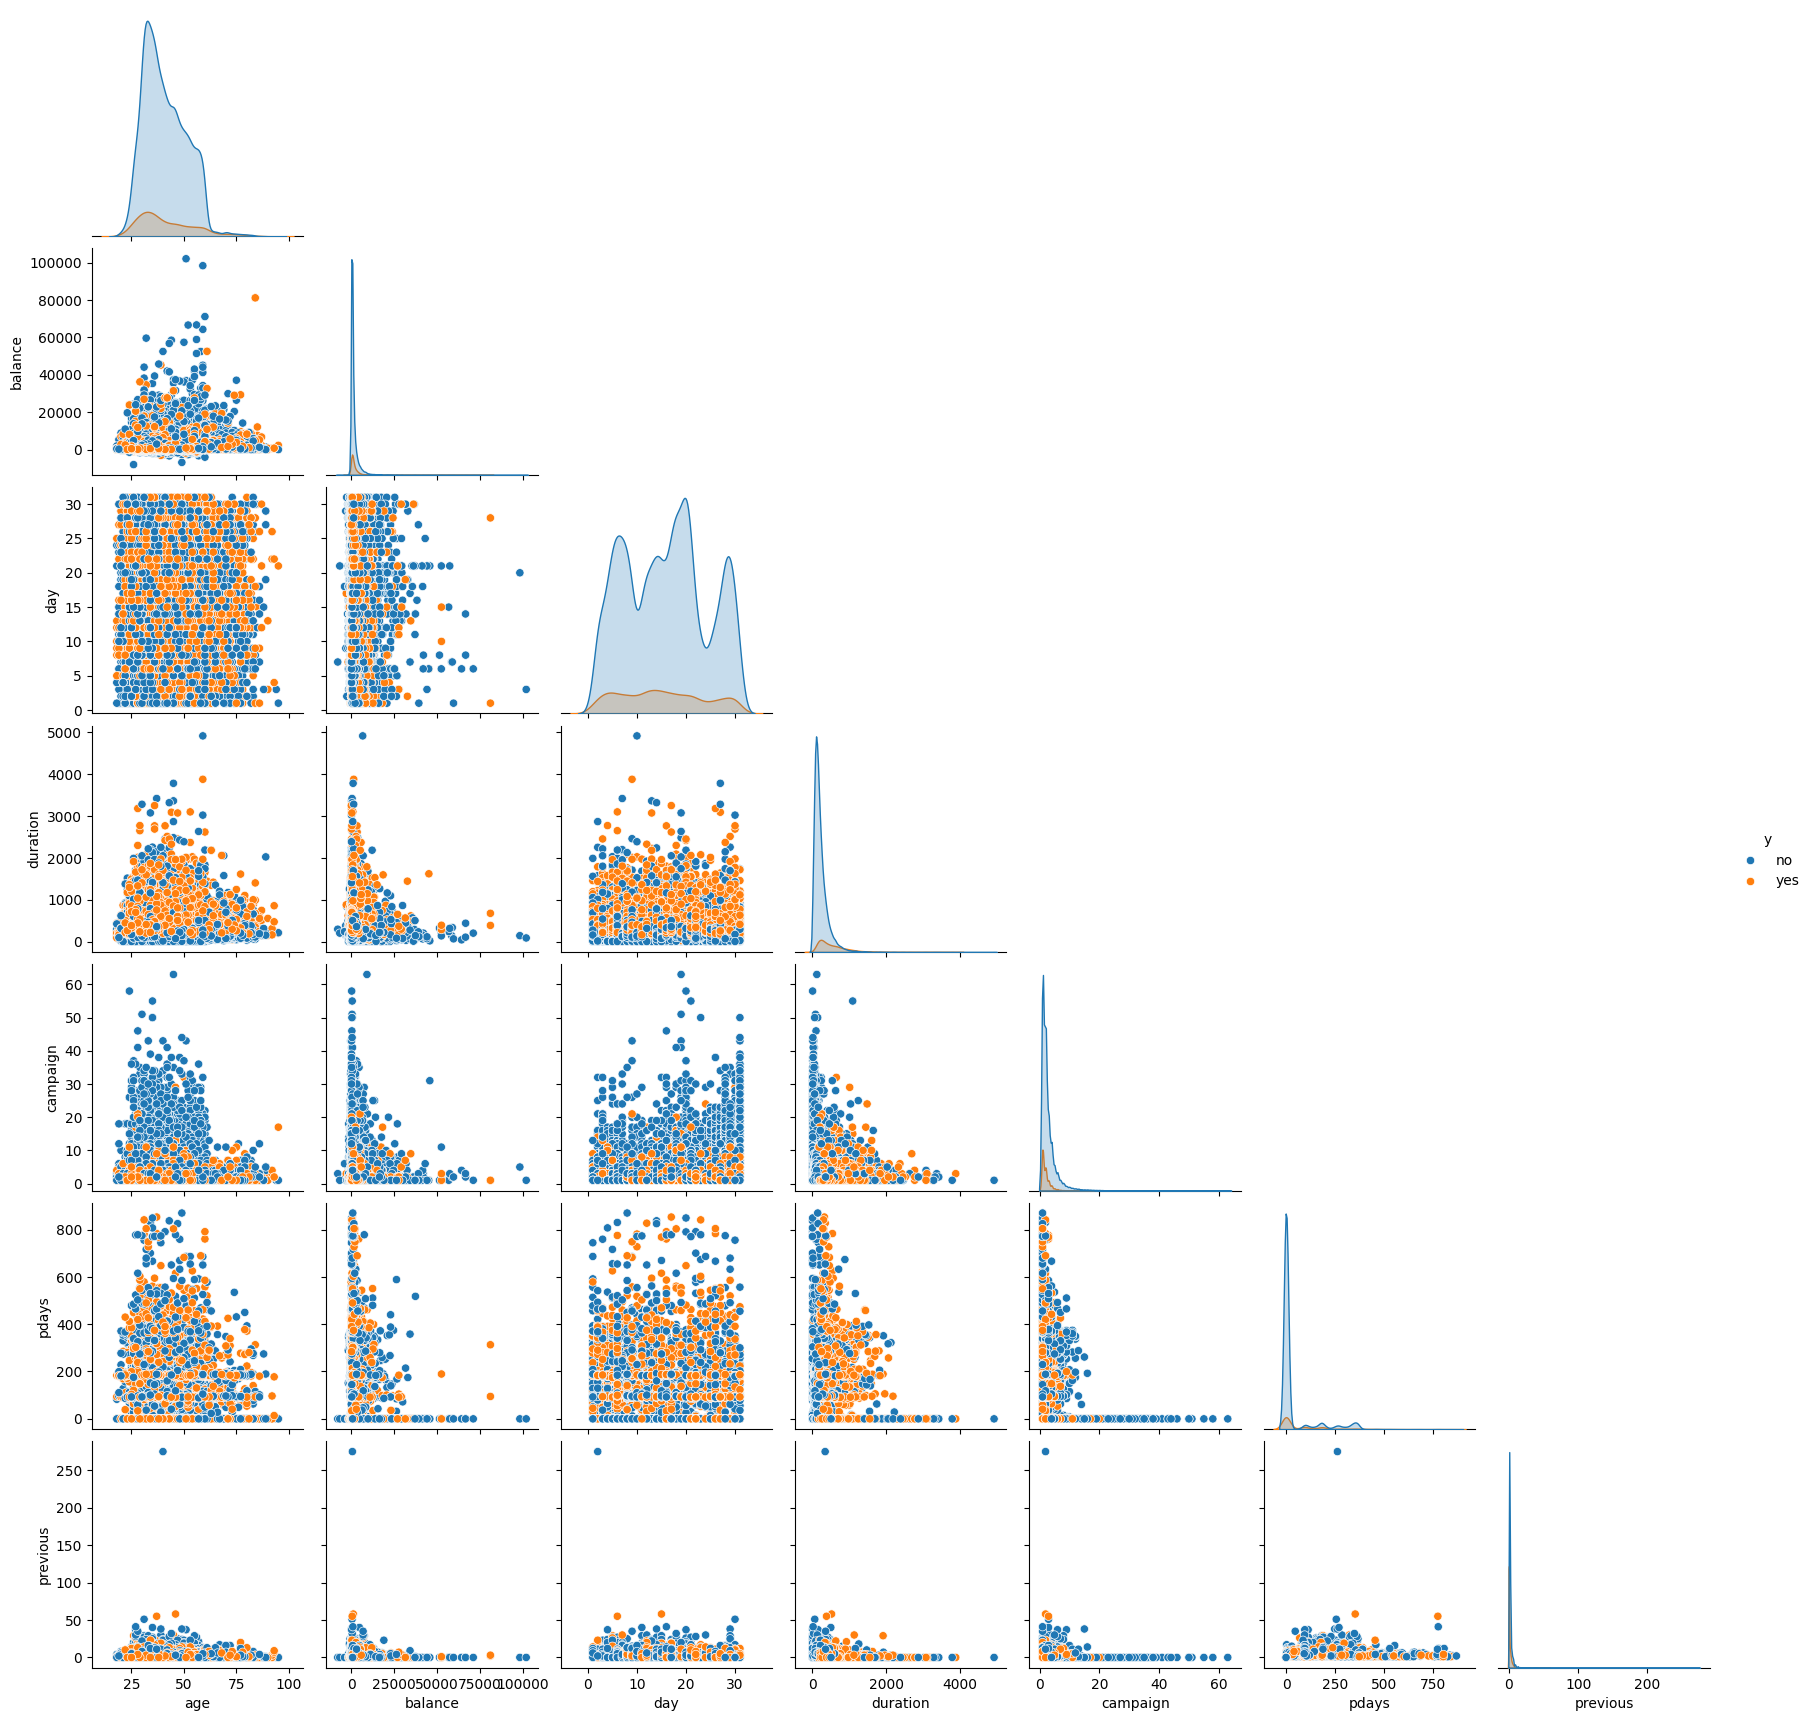

In [12]:
# 3D Scatter plot with hue
sns.pairplot(dfBnk,hue='y',corner=True)


<Axes: xlabel='age', ylabel='balance'>

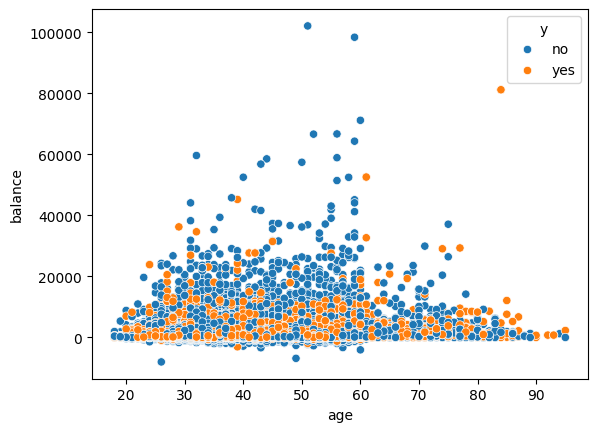

In [13]:
sns.scatterplot(x=dfBnk['age'], y=dfBnk['balance'], hue=dfBnk['y'])


The associations between attributes is analized and saw that the orange points is clusterd more on left in balance/age plot

## Predict whether the person subscribed or not

We will not be able to use Linear Regression because our target is binary and not continuous.  So, let's transform the linear model into something that would split the output into two 'classes'...

\Such problems are known as **Classification Models**, and let's try a few different models.

### Logistic Regression

In logistic regression, we take the output of the linear function and squash the value within the range of [0,1] using the sigmoid function( logistic function). The Sigmoid-Function is an S-shaped curve that can take any real-valued number and map it into a value between the range of 0 and 1, but never exactly at those limits. Typically, if the squashed value is greater than a threshold value we assign it a label 1, else we assign it a label 0.

In [14]:
# Scale data to eliminate the effect of feature units (especially for gradient descent cases)
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder

dfBnk['y'] = dfBnk['y'].map({'yes': 1, 'no': 0})


y = dfBnk['y']
X = dfBnk.drop(['y'], axis=1)


# Identify columns with object (string) dtype
object_cols = X.select_dtypes(include=['object']).columns

# Apply label encoding to object columns
label_encoder = LabelEncoder()
for col in object_cols:
    X[col] = label_encoder.fit_transform(X[col])

# Now scale the numerical data
X_s = scale(X)



X_train, X_test, y_train, y_test = train_test_split(X_s, y,train_size=0.8, test_size=0.2,random_state=1)

In [15]:
# Build Logistic Regression model
from sklearn.linear_model import LogisticRegression


mdlLgrBnk = LogisticRegression(random_state=1)
mdlLgrBnk.fit(X_train, y_train)
y_test_pred = mdlLgrBnk.predict(X_test)

Since target is binary and not continuous, we cannot directly compare the prediction with the actual.  So, let's view the model result in a table - also known as a **Confusion Matrix**.

In [ ]:
# Display model results using
from sklearn.metrics import confusion_matrix

print ('Confusion Matrix:')
print (confusion_matrix(y_test, y_test_pred))

Confusion Matrix:
[[7837  156]
 [ 830  220]]


#### Detailed calcs

## Metric 1: F1-score
The F1-score is simply the harmonic mean of the precision and recall

In [ ]:
# Display performance results
from sklearn.metrics import classification_report

print ('Classification Report (Logistic Regression):')
print (classification_report(y_test, y_test_pred))

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7993
           1       0.59      0.21      0.31      1050

    accuracy                           0.89      9043
   macro avg       0.74      0.60      0.62      9043
weighted avg       0.87      0.89      0.87      9043



## Metric 2: ROC AUC Score

To summarize all the performance results into a single number, let's plot the
True Positive Rate (TPR) = TP / (TP + FN) = 25/31
against
False Positive Rate (FPR) = FP / (FP + TN) = 10/30

An **ROC (Receiver Operating Characteristic) curve** plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

A higher value for the area under this ROC curve, aka **AUC**, signifies a better model.

In [ ]:
# Display summary results

from sklearn.metrics import roc_auc_score

print ('AUC Score (Logistic Regression):')
print (roc_auc_score(y_test, y_test_pred))

AUC Score (Logistic Regression):
0.5950033660405235


Now that we have one working model with acceptable results, let's see if we can improve it by trying out some other models...

### Naive Bayes
This is a different way of getting to a similar outcome. Naive Bayes is a probabilistic model that uses Bayes Theorem to predict probability of target value given features based on the probability of features given the target.

In other words,

A => P(target=Y|X) = P(X|target=Y).P(target=Y) / P(X)

B => P(target=N|X) = P(X|target=N).P(target=N) / P(X)

If A/(A+B) >0.5, then predict A, else B

#### Naive Bayes - Gaussian
Since the pairplot showed normally distributed features (along the diagonal), the Gaussian Naive Bayes would be a good model to try...

In [ ]:
# Build Naive Bayes - Gaussian model
from sklearn.naive_bayes import GaussianNB

mdlNbgBnk = GaussianNB()
mdlNbgBnk.fit(X_train,y_train)
y_test_pred = mdlNbgBnk.predict(X_test)

print ('Results (Naive Bayes - Gaussian):\n')

print ('Classification Report:')
print (classification_report(y_test, y_test_pred))

print ('AUC Score:')
print (roc_auc_score(y_test, y_test_pred))

Results (Naive Bayes - Gaussian):

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      7993
           1       0.35      0.49      0.40      1050

    accuracy                           0.83      9043
   macro avg       0.64      0.68      0.65      9043
weighted avg       0.86      0.83      0.85      9043

AUC Score:
0.6827803494724551


### K-Nearest Neighbor (KNN)
This is yet another way of getting to a similar outcome, but this time using cartesian distances to determine how close or far a new data point is to the previous data points.

In [ ]:
# Build KNN model with 1 to 10 nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

# Iterate over different values of k
for k in range(1, 11):
    # Build KNN model
    mdlKnnHrt = KNeighborsClassifier(n_neighbors=k)
    mdlKnnHrt.fit(X_train, y_train)

    # Predict on test set
    y_test_pred = mdlKnnHrt.predict(X_test)

    # Calculate and print AUC score
    auc = roc_auc_score(y_test, y_test_pred)
    print(f'AUC Score (K-Nearest Neighbor, k={k}): {auc}')

AUC Score (K-Nearest Neighbor, k=1): 0.6708674256641228
AUC Score (K-Nearest Neighbor, k=2): 0.596720463739105
AUC Score (K-Nearest Neighbor, k=3): 0.6682411395685511
AUC Score (K-Nearest Neighbor, k=4): 0.6058689448505538
AUC Score (K-Nearest Neighbor, k=5): 0.6563911875271815
AUC Score (K-Nearest Neighbor, k=6): 0.6127475231303581
AUC Score (K-Nearest Neighbor, k=7): 0.6440063627102286
AUC Score (K-Nearest Neighbor, k=8): 0.6122955800611249
AUC Score (K-Nearest Neighbor, k=9): 0.6412985767308299
AUC Score (K-Nearest Neighbor, k=10): 0.6071200395584232


The performance of the K-Nearest Neighbors (KNN) method is greatly affected by changes to the value of k. The model's sensitivity to noise in the training data increases with small k values (e.g., k=1), which also increases the model's variance and produces more varied AUC ratings. By taking into account more neighbors, moderate k values (k=3, k=5) help to smooth out decision boundaries and produce typically more stable and better results. However, because the model includes points from several classes, it begins to underfit when k is too high (e.g., k=8, k=10), which lowers performance. Based on this pattern, we may conclude that the ideal k value is between k=1 and k=3, as these values yield AUC scores that are comparatively higher and more stable than those of the other values.


Let's try a different type of classification model before we wrap up...

### Support Vector Machines
While Logistic Regression and Naive Bayes are probabilistic models, Support Vector Machines try to create a boundary that maximize the margin between the different classes.

In [ ]:
# Build Support Vector Machines - Classifier model

from sklearn.svm import SVC

mdlSvmHrt = SVC()
mdlSvmHrt.fit(X_train, y_train)
y_test_pred = mdlSvmHrt.predict(X_test)


print ('Results (Support Vector Classifier):\n')

print ('Classification Report:')
print (classification_report(y_test, y_test_pred))

print ('AUC Score:')
print (roc_auc_score(y_test, y_test_pred))

Results (Support Vector Classifier):

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7993
           1       0.67      0.27      0.38      1050

    accuracy                           0.90      9043
   macro avg       0.79      0.62      0.66      9043
weighted avg       0.88      0.90      0.88      9043

AUC Score:
0.6247007798490346


Based on all the above models, it seems like Naive Bayes gives us the best results with an AUC score of 69%.  

## Takeaways

* Explored a new area of Machine Learning to predict categorical target as opposed to numerical targets via *Classification Models*
* Built different types of Classification Models such as *Logistic Regression*, *Naive Bayes Classifiers*, *K-Nearest Neighbor Classifiers* and *Support Vector Machines*
* Compared the different models using the *Confusion Matrix* and the *AUC Score* to select the best model